In [145]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.LAST)



data, target = dataloader.get_econmical_classification_dataset_and_target()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_dir:  /Users/hugojarudd/Desktop/kdd-process/src


In [146]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)
from pandas import Series, DataFrame
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart
import pandas as pd
from sklearn.model_selection import train_test_split


## Train test split


In [147]:
#Shift data to positive valiues to be able to use naive bayes

data_min = data.min()
data = data-data_min

train, test = train_test_split(data, test_size=0.2, random_state=42)


# Correlation analysis

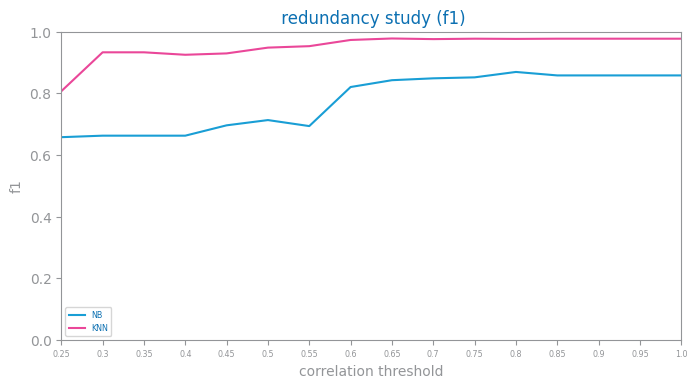

In [148]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    #savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


eval_metric = "f1"

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    #file_tag=file_tag,
)
show()


## From the graph above it can be seen that dropping variables with correlation higher than 0.6 is beneficial for both models

In [149]:
def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop_corr: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.6
)
print("Variables to drop", sorted(vars2drop_corr))

Original variables ['Company' 'Time' 'Financial Distress' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x8'
 'x9' 'x10' 'x11' 'x12' 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20' 'x21'
 'x22' 'x23' 'x24' 'x25' 'x26' 'x27' 'x28' 'x29' 'x30' 'x31' 'x32' 'x35'
 'x36' 'x37' 'x39' 'x40' 'x41' 'x42' 'x43' 'x44' 'x45' 'x46' 'x47' 'x51'
 'x54' 'x55' 'x56' 'x57' 'x58' 'x59' 'x60' 'x61' 'x63' 'x64' 'x65' 'x66'
 'x67' 'x68' 'x69' 'x70' 'x71' 'x72' 'x73' 'x74' 'x78' 'x80' 'x82' 'x83'
 'CLASS']
Variables to drop ['Time', 'x1', 'x10', 'x14', 'x16', 'x19', 'x2', 'x23', 'x24', 'x25', 'x3', 'x30', 'x32', 'x35', 'x36', 'x40', 'x41', 'x43', 'x44', 'x46', 'x5', 'x59', 'x61', 'x63', 'x64', 'x68', 'x70', 'x73', 'x78', 'x8', 'x9']


In [150]:
data = data.drop(columns=vars2drop_corr)

# Variability analysis

In [151]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "CLASS"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)



print("Original variables", train.columns.to_list())
vars2drop_var: list[str] = select_low_variance_variables(train, 0.5, target=target)
print("Variables to drop", vars2drop_var)

Original variables ['Company', 'Time', 'Financial Distress', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x35', 'x36', 'x37', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x51', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x78', 'x80', 'x82', 'x83', 'CLASS']
Variables to drop ['x12', 'x20', 'x25', 'x54', 'x57']


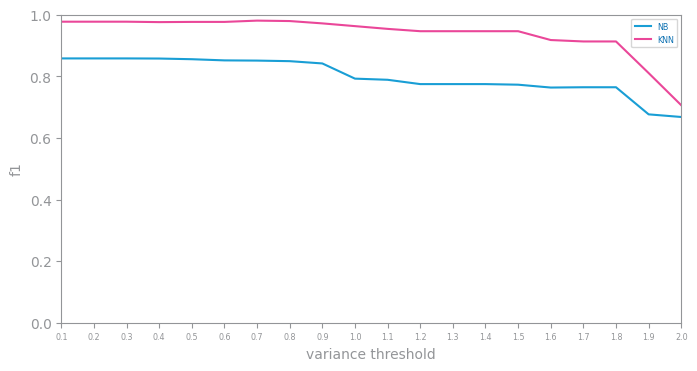

In [152]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    #file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        #title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    #savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "f1"


figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=2,
    lag=0.1,
    metric=eval_metric,
    #file_tag=file_tag,
)
show()


Since there is no increase in performance by dropping high variance variables, no high variance variables will be dropped.

In [153]:

print(vars2drop_var)
print(vars2drop_corr)

vars2drop = set(vars2drop_corr+vars2drop_var)
print(vars2drop)

#data = data.drop(columns=vars2drop)

#print(data.columns.values)

['x12', 'x20', 'x25', 'x54', 'x57']
['x61', 'x64', 'x68', 'x73', 'x43', 'x44', 'x46', 'x3', 'x5', 'x9', 'x10', 'x23', 'x25', 'x36', 'x2', 'x14', 'x24', 'x16', 'x19', 'x32', 'x59', 'x30', 'x40', 'x41', 'x8', 'x35', 'x1', 'Time', 'x63', 'x70', 'x78']
{'x68', 'x43', 'x2', 'Time', 'x10', 'x36', 'x8', 'x32', 'x59', 'x73', 'x78', 'x41', 'x3', 'x30', 'x9', 'x1', 'x12', 'x23', 'x57', 'x19', 'x40', 'x5', 'x44', 'x46', 'x64', 'x35', 'x63', 'x61', 'x25', 'x24', 'x14', 'x20', 'x70', 'x54', 'x16'}
